In [3]:
import numpy as np
import h5py
import torch
import os
import matplotlib.pyplot as plt

In [4]:
def load_final_model_performaces(cv_results_path, filename, h5_path=None, num_clients=14, num_folds=5):
    if h5_path is None:
        h5_path = os.path.join(cv_results_path, filename)
    
    # Load data from HDF5 file
    with h5py.File(h5_path, 'r') as f:
        a_group_key = list(f.keys())
        extraction_dict = dict()
        final_clients_loss_lst = []
        
        for key in a_group_key:
            extraction_dict[key] = f[key][()]
            if isinstance(f[key][()], np.ndarray):
                final_clients_loss_lst.append(f[key][()][-1])
    
    # Organize loss by client
    client_data_lst = [[] for _ in range(num_clients)]
    
    for trial_idx in range(num_folds):
        for client_idx in range(num_clients):
            index = trial_idx * num_clients + client_idx
            client_data_lst[client_idx].append(final_clients_loss_lst[index])
    
    # Compute mean loss for each client
    client_final_loss_lst = [np.mean(np.array(client_data_lst[client_idx])) for client_idx in range(num_clients)]
    
    # Print results
    #for i, client in enumerate(client_data_lst):
    #    print(f"Client {i+1}: {client}")
    #print("Client final loss list:", client_final_loss_lst)
    
    return client_final_loss_lst


In [6]:
# INTRA
intra_nofl = load_final_model_performaces(r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results\08-21_22-02_NOFL', 'FULLSCIPYMIN_NOFL_CrossValResults.h5')
intra_fedavg = load_final_model_performaces(r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results\08-21_22-06_FEDAVG', 'GDLS_FEDAVG_CrossValResults.h5')
intra_pfa1 = load_final_model_performaces(r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results\08-21_22-07_PFAFO_GDLS', 'GDLS_PFAFO_GDLS_CrossValResults.h5')
intra_pfa2 = load_final_model_performaces(r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results\08-21_22-09_PFAFO_GDLS', 'GDLS_PFAFO_GDLS_CrossValResults.h5')

# CROSS
cross_pfa = load_final_model_performaces(r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results\08-21_18-08_PFAFO_GDLS', 'GDLS_PFAFO_GDLS_CrossValResults.h5')
cross_fedavg = load_final_model_performaces(r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results\08-21_18-07_FEDAVG', 'GDLS_FEDAVG_CrossValResults.h5')
cross_nofl = load_final_model_performaces(r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results\08-21_16-24_NOFL', 'FULLSCIPYMIN_NOFL_CrossValResults.h5')
#load_final_model_performaces(r'', filename)

In [15]:
all_trials_lst = [intra_nofl, intra_fedavg, intra_pfa1, cross_nofl, cross_fedavg, cross_pfa]
NUM_TRIALS = 6
NUM_CLIENTS = 14
NUM_FOLDS = 5

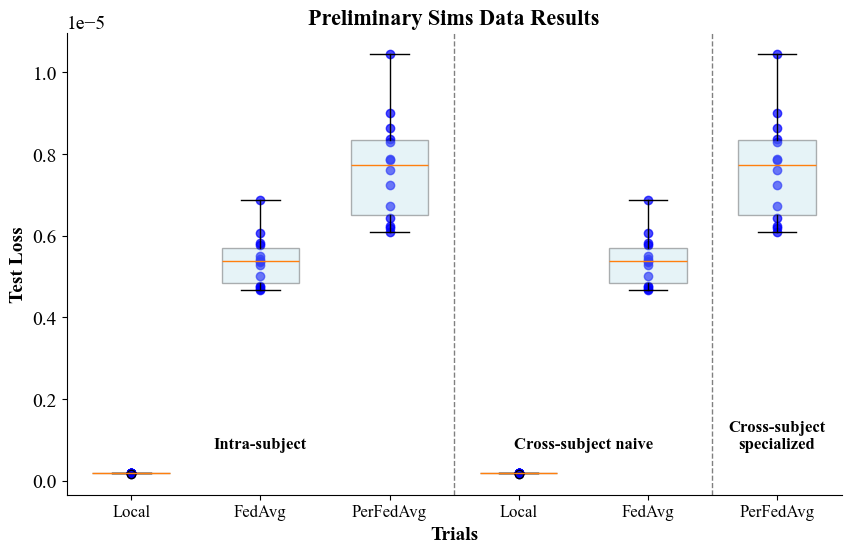

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define x-tick labels and corresponding subgroup labels
x_labels = ['Local', 'FedAvg', 'PerFedAvg', 'Local', 'FedAvg', 'PerFedAvg']
subgroup_labels = ['Intra-subject', 'Cross-subject naive', 'Cross-subject\nspecialized']

# Positions for the boxplots
positions = np.arange(len(x_labels))

# Plotting the boxplots with transparent boxes
boxplot_elements = ax.boxplot(all_trials_lst, positions=positions, widths=0.6, patch_artist=True)

# Set the transparency for the boxes
for box in boxplot_elements['boxes']:
    box.set_facecolor('lightblue')  # Set box color
    box.set_alpha(0.3)  # Set transparency (0: fully transparent, 1: fully opaque)

# Plotting the scatter points over the boxplots
for i in range(NUM_TRIALS):
    # Scatter plot of points for each trial
    ax.scatter([i]*NUM_CLIENTS, all_trials_lst[i], alpha=0.7, color='blue')

# Set the x-tick labels
ax.set_xticks(positions)
ax.set_xticklabels(x_labels, fontsize=12)

# Adding vertical lines for separation
ax.axvline(x=2.5, color='gray', linestyle='--', linewidth=1)
ax.axvline(x=4.5, color='gray', linestyle='--', linewidth=1)

# Get axis limits and adjust text positioning accordingly
ax = plt.gca()  # Get current axis
ylim = ax.get_ylim()  # Get y-axis limits
# Place text closer to the x-axis based on ylim
y_position = ylim[0] + 0.1 * (ylim[1] - ylim[0])  # Adjust the position just below the x-axis
# Adding subgroup labels below the x-tick labels with better positioning
ax.text(1, y_position, 'Intra-subject', ha='center', fontsize=12, weight='bold')
ax.text(3.5, y_position, 'Cross-subject naive', ha='center', fontsize=12, weight='bold')
ax.text(5, y_position, 'Cross-subject\nspecialized', ha='center', fontsize=12, weight='bold')


# Axis labels
ax.set_ylabel("Test Loss", fontsize=14, fontweight='bold')
ax.set_xlabel("Trials", fontsize=14, fontweight='bold')
ax.set_title("Preliminary Sims Data Results", fontsize=16, fontweight='bold')

# Customizing fonts globally (optional, can be changed)
plt.rcParams.update({
    'font.family': 'serif',  # Choose a serif font
    'font.serif': ['Times New Roman'],  # Set to Times New Roman (if available)
    'font.size': 14,  # Adjust default font size
    'axes.titlesize': 16,  # Title font size
    'axes.labelsize': 14,  # Label font size
    'legend.fontsize': 12,  # Legend font size
})

# Remove top and right plot borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

# Tight layout for better spacing
#plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import numpy as np

# Ground truth (actual) and predicted values
y_true = np.array([...])  # Ground truth values
y_pred = np.array([...])  # Predicted values

# Calculate the residual sum of squares
ss_res = np.sum((y_true - y_pred) ** 2)

# Calculate the total sum of squares
ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)

# Calculate R^2
r_squared = 1 - (ss_res / ss_tot)

print(f"R^2: {r_squared}")
